# Within-session Analysis of Neuropixel Data

In [203]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Show all columns when printing data
pd.set_option('display.max_columns', None)

## 1. Loading a session

In [2]:
# Specify home path and a .json file
# HOME = Path().cwd()
# HOME = Path('/media/internal/data/neuropixel')
HOME = Path('D:\Data\Allen_Ecephys')
manifest_path = HOME / 'data' / 'Ecephy' / "manifest.json"

In [3]:
# Project-level object that fetches from Allen's public API (warehouse)
# uses .json file to point to a cache directory
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [4]:
table = cache.get_session_table()
table.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


In [5]:
# Find unique session IDs
session_ids = np.unique(table.index)
session_ids

array([715093703, 719161530, 721123822, 732592105, 737581020, 739448407,
       742951821, 743475441, 744228101, 746083955, 750332458, 750749662,
       751348571, 754312389, 754829445, 755434585, 756029989, 757216464,
       757970808, 758798717, 759883607, 760345702, 760693773, 761418226,
       762120172, 762602078, 763673393, 766640955, 767871931, 768515987,
       771160300, 771990200, 773418906, 774875821, 778240327, 778998620,
       779839471, 781842082, 786091066, 787025148, 789848216, 791319847,
       793224716, 794812542, 797828357, 798911424, 799864342, 816200189,
       819186360, 819701982, 821695405, 829720705, 831882777, 835479236,
       839068429, 839557629, 840012044, 847657808], dtype=int64)

In [6]:
# How many sessions are there? 
session_ids.shape[0]

58

In [7]:
# Load a session
session = cache.get_session_data(session_ids[11])

Downloading:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

In [8]:
session.metadata

{'specimen_name': 'C57BL/6J-412792',
 'session_type': 'brain_observatory_1.1',
 'full_genotype': 'wt/wt',
 'sex': 'M',
 'age_in_days': 92.0,
 'rig_equipment_name': 'NP.1',
 'num_units': 761,
 'num_channels': 2223,
 'num_probes': 6,
 'num_stimulus_presentations': 70390,
 'session_start_time': datetime.datetime(2018, 10, 26, 12, 58, 51, tzinfo=tzoffset(None, -25200)),
 'ecephys_session_id': 750749662,
 'structure_acronyms': ['VISpm',
  nan,
  'PO',
  'LD',
  'LP',
  'DG',
  'CA1',
  'LGd',
  'CA3',
  'VISrl',
  'Eth',
  'VISam',
  'VISp',
  'LGv',
  'IGL',
  'VISl',
  'VISal',
  'VPM',
  'TH',
  'CA2'],
 'stimulus_names': ['spontaneous',
  'gabors',
  'flashes',
  'drifting_gratings',
  'natural_movie_three',
  'natural_movie_one',
  'static_gratings',
  'natural_scenes']}

In [9]:
session.structurewise_unit_counts

LP       142
CA1      113
LGd       82
VISam     64
VISpm     64
VPM       55
VISp      52
VISal     46
VISrl     41
PO        30
DG        26
VISl      20
TH        13
CA3       10
Eth        2
LD         1
Name: ecephys_structure_acronym, dtype: int64

## 2. Select stimuli and region

Let's just work with **Drifting Gratings** and **V1**.

In [10]:
stim_type = 'drifting_gratings'
roi = 'VISp'

# get just one stimulus condition, can look up later what its parameters are 
stim_id = session.stimulus_conditions.loc[session.stimulus_conditions.stimulus_name == stim_type].index.values[0]
stim_idx = session.stimulus_presentations.loc[session.stimulus_presentations.stimulus_condition_id == stim_id].index.values

# select the roi and also drop low-snr units
q25 = np.percentile(session.units.snr, 25)
# mean_snr = session.units.snr.mean()
roi_idx = session.units[(session.units.snr > q25) & (session.units.ecephys_structure_acronym == roi)].index.values

In [11]:
# Sanity check
session.units.loc[roi_idx, :].shape

(43, 89)

In [12]:
stim_id

246

In [13]:
len(stim_idx)

15

In [14]:
session.stimulus_presentations.loc[stim_idx, :]

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3798,null,0.8,null,135.0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1585.570019,2.0,drifting_gratings,1587.571669,2.0,null,null,2.00165,246
3810,null,0.8,null,135.0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1621.600109,2.0,drifting_gratings,1623.601799,2.0,null,null,2.00169,246
3828,null,0.8,null,135.0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1675.645229,2.0,drifting_gratings,1677.646929,2.0,null,null,2.00170,246
3904,null,0.8,null,135.0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1903.835839,2.0,drifting_gratings,1905.837529,2.0,null,null,2.00169,246
3983,null,0.8,null,135.0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,2141.033992,2.0,drifting_gratings,2143.035672,2.0,null,null,2.00168,246
31029,null,0.8,null,135.0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,3260.969519,5.0,drifting_gratings,3262.971159,2.0,null,null,2.00164,246
31115,null,0.8,null,135.0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,3519.185179,5.0,drifting_gratings,3521.186869,2.0,null,null,2.00169,246
31160,null,0.8,null,135.0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,3654.298062,5.0,drifting_gratings,3656.299752,2.0,null,null,2.00169,246
49225,null,0.8,null,135.0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,4774.233789,7.0,drifting_gratings,4776.235479,2.0,null,null,2.00169,246


In [15]:
stim_times = session.stimulus_presentations.loc[stim_idx, ["start_time"]]
stim_times["relative_time"] = (stim_times["start_time"] - stim_times["start_time"].min()) / 60
stim_times

,start_time,relative_time
stimulus_presentation_id,,
3798,1585.570019,0.000000
3810,1621.600109,0.600501
3828,1675.645229,1.501253
3904,1903.835839,5.304430
3983,2141.033992,9.257733
31029,3260.969519,27.923325
31115,3519.185179,32.226919
31160,3654.298062,34.478801
49225,4774.233789,53.144396


## 3. Spike counts and visualization

In [132]:
time_step = .03
time_bins = np.arange(-0.1, 0.5 + time_step, time_step)

In [133]:
spike_cnts = session.presentationwise_spike_counts(
    stimulus_presentation_ids=stim_idx,  
    unit_ids=roi_idx,
    bin_edges=time_bins
)
cnts = spike_cnts.to_dataframe()

In [134]:
cnts.reset_index(inplace=True)

C:\Users\shari\miniconda3\envs\neuro\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


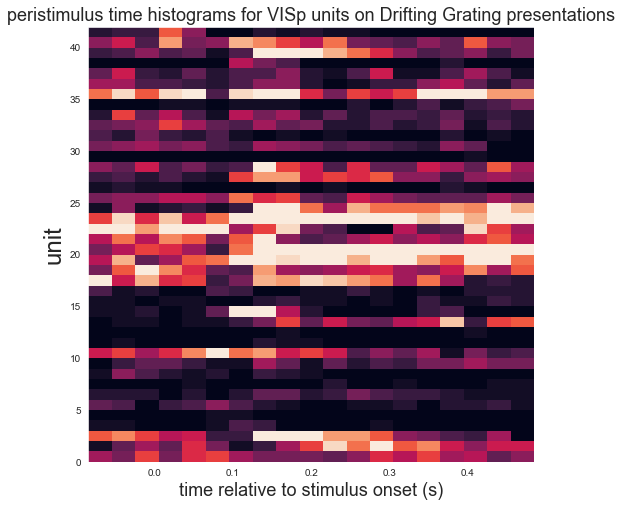

In [135]:
mean_histograms = spike_cnts.mean(dim="stimulus_presentation_id")

fig, ax = plt.subplots(figsize=(8, 8))
ax.pcolormesh(
    mean_histograms["time_relative_to_stimulus_onset"], 
    np.arange(mean_histograms["unit_id"].size),
    mean_histograms.T, 
    vmin=0,
    vmax=1
)

ax.set_ylabel("unit", fontsize=24)
ax.set_xlabel("time relative to stimulus onset (s)", fontsize=18)
ax.set_title("peristimulus time histograms for VISp units on Drifting Grating presentations", fontsize=18)

plt.show()

In [136]:
spikes = session.conditionwise_spike_statistics(
    stimulus_presentation_ids=stim_idx,
    unit_ids=roi_idx
)

spikes

,,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
unit_id,stimulus_condition_id,,,,,
951877136,3887,10,20,0.50,0.512989,0.114708
951877260,3887,9,20,0.45,0.759155,0.169752
951877272,3887,9,20,0.45,0.686333,0.153469
951877312,3887,0,20,0.00,0.000000,0.000000
951877352,3887,0,20,0.00,0.000000,0.000000
951877391,3887,2,20,0.10,0.307794,0.068825
951877405,3887,4,20,0.20,0.410391,0.091766
951877505,3887,1,20,0.05,0.223607,0.050000
951877547,3887,17,20,0.85,0.745160,0.166623


In [137]:
spikes = session.conditionwise_spike_statistics(
    stimulus_presentation_ids=stim_idx,
    unit_ids=roi_idx
)

# display the parameters associated with each condition
spikes = pd.merge(spikes, session.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)

spikes.head()

,,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem,color,contrast,frame,mask,opacity,orientation,phase,size,spatial_frequency,stimulus_name,temporal_frequency,units,x_position,y_position,color_triplet
unit_id,stimulus_condition_id,,,,,,,,,,,,,,,,,,,,
951877136,3887,10,20,0.50,0.512989,0.114708,null,1.0,0.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
951877260,3887,9,20,0.45,0.759155,0.169752,null,1.0,0.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
951877272,3887,9,20,0.45,0.686333,0.153469,null,1.0,0.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
951877312,3887,0,20,0.00,0.000000,0.000000,null,1.0,0.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
951877352,3887,0,20,0.00,0.000000,0.000000,null,1.0,0.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"


In [138]:
all_spikes = session.presentationwise_spike_times(
    stimulus_presentation_ids=stim_idx,  
    unit_ids=roi_idx,
)
cols = ["start_time", "stop_time", "stimulus_block", "orientation", "temporal_frequency", "stimulus_name", "stimulus_condition_id"]
all_spikes = pd.merge(all_spikes, session.stimulus_presentations[cols], left_on="stimulus_presentation_id", right_index=True)

In [139]:
all_spikes

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset,start_time,stop_time,stimulus_block,orientation,temporal_frequency,stimulus_name,stimulus_condition_id
spike_time,,,,,,,,,,
2846.633214,22000,951878511,0.009825,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887
2846.635780,22000,951877136,0.012391,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887
2846.654647,22000,951878011,0.031258,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887
2876.649220,22900,951877960,0.000721,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887
2876.650553,22900,951878022,0.002054,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887
...,...,...,...,...,...,...,...,...,...,...
7980.957818,65218,951878811,0.027609,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887
7980.958751,65218,951878011,0.028542,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887
7980.960451,65218,951878032,0.030242,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887


In [140]:
all_spikes.reset_index(inplace=True)

In [141]:
# Limit number of spikes to 0.5s after stimulus presentation
all_spikes = all_spikes[all_spikes.time_since_stimulus_presentation_onset < 0.5]

In [142]:
all_spikes

,spike_time,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset,start_time,stop_time,stimulus_block,orientation,temporal_frequency,stimulus_name,stimulus_condition_id
0,2846.633214,22000,951878511,0.009825,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887
1,2846.635780,22000,951877136,0.012391,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887
2,2846.654647,22000,951878011,0.031258,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887
3,2876.649220,22900,951877960,0.000721,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887
4,2876.650553,22900,951878022,0.002054,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887
...,...,...,...,...,...,...,...,...,...,...,...
290,7980.957818,65218,951878811,0.027609,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887
291,7980.958751,65218,951878011,0.028542,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887
292,7980.960451,65218,951878032,0.030242,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887
293,7980.960618,65218,951878648,0.030409,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887


In [143]:
# Count the number of spikes for each stimulus presentation during the 0.5s
grp_cols = ["stimulus_presentation_id", "unit_id"] + cols
spikes_grpd = all_spikes.groupby(grp_cols, as_index=False)["spike_time"].count()

# Add the time in minutes to know how far stimuli have been presented
for pres in spikes_grpd.stimulus_presentation_id.unique():
    spikes_grpd.loc[spikes_grpd.stimulus_presentation_id == pres, "relative_time"] = stim_times.loc[pres, "relative_time"]

# Rename    
spikes_grpd.rename(columns={"spike_time": "spike_count"}, inplace=True)
spikes_grpd.head()

,stimulus_presentation_id,unit_id,start_time,stop_time,stimulus_block,orientation,temporal_frequency,stimulus_name,stimulus_condition_id,spike_count,relative_time
0,22000,951877136,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000
1,22000,951878011,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000
2,22000,951878511,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000
3,22900,951877391,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887,1,0.500419
4,22900,951877405,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887,1,0.500419


<mark> Some of the units are lost when thresholding to 0.5s after stimulus onset, some do not spike at all for a given presentation! The numbers below don't match the total number of units (43) x number of presentations (15)</mark>

In [144]:
len(spikes_grpd)

232

In [145]:
all_spikes.loc[all_spikes.stimulus_presentation_id == 3798, "unit_id"].unique().shape

(0,)

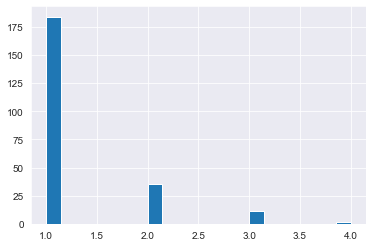

In [146]:
# Sanity check plots
p = plt.hist(spikes_grpd["spike_count"], len(time_bins))

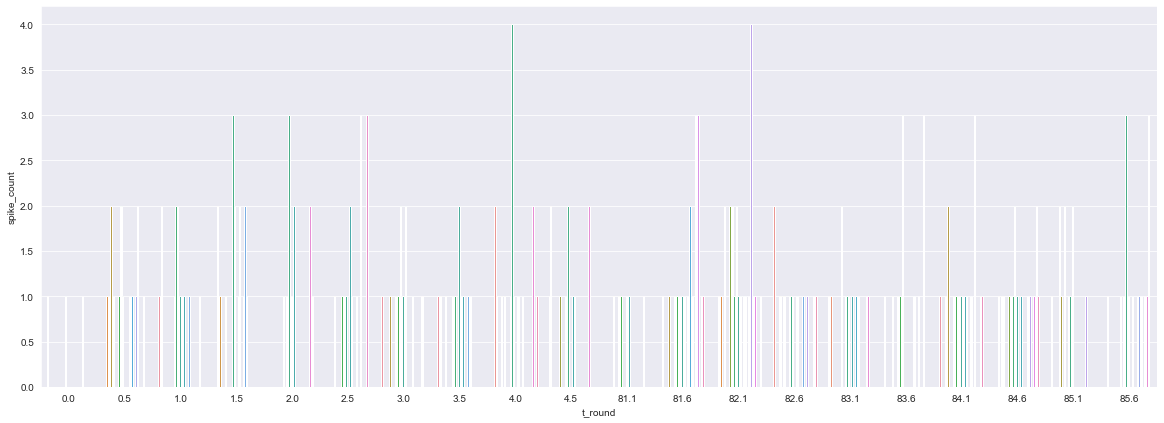

In [147]:
fig, ax = plt.subplots(figsize=(20, 7))
spikes_grpd["t_round"] = np.around(spikes_grpd["relative_time"], 1)
plot = sns.barplot(x='t_round', y='spike_count', hue='unit_id', ax=ax, data=spikes_grpd)
# plot.set_xticklabels(np.arange(1, len(spikes_grpd.unit_id.unique()) + 1))
plot.legend_.remove()

In [148]:
# Check suspicious units' snr
suspicious = spikes_grpd[spikes_grpd.spike_count > 60]["unit_id"].to_numpy()
for sus in np.unique(suspicious):
    snr = session.units.loc[sus, "snr"]
    print(f"Unit {sus}: {snr}")

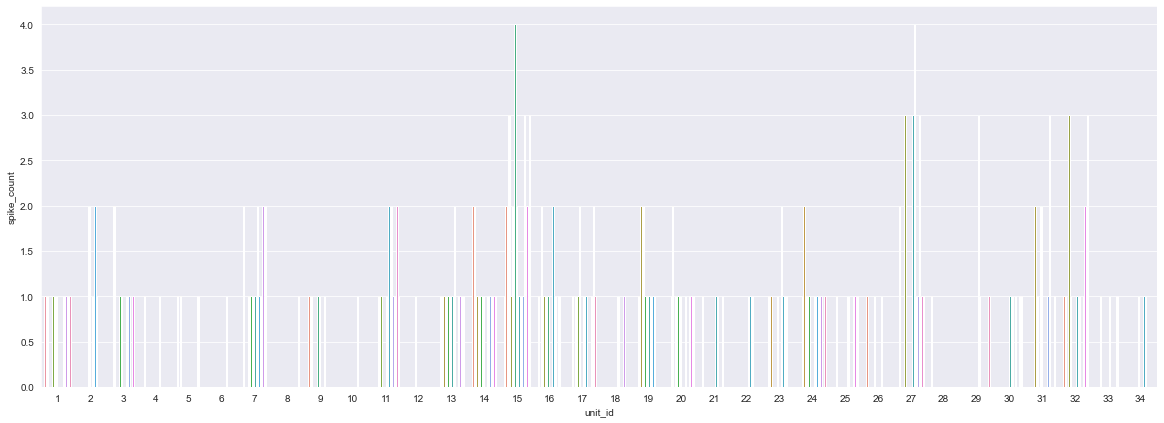

In [149]:
fig, ax = plt.subplots(figsize=(20, 7))
plot = sns.barplot(x='unit_id', y='spike_count', hue='stimulus_presentation_id', ax=ax, data=spikes_grpd)
plot.set_xticklabels(np.arange(1, len(spikes_grpd.unit_id.unique()) + 1))
plot.legend_.remove()

In [150]:
# This is the final spike counts for this stimulus and this region
df = spikes_grpd.copy()
df["roi"] = roi
df

,stimulus_presentation_id,unit_id,start_time,stop_time,stimulus_block,orientation,temporal_frequency,stimulus_name,stimulus_condition_id,spike_count,relative_time,t_round,roi
0,22000,951877136,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000,0.0,VISp
1,22000,951878011,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000,0.0,VISp
2,22000,951878511,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000,0.0,VISp
3,22900,951877391,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887,1,0.500419,0.5,VISp
4,22900,951877405,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887,1,0.500419,0.5,VISp
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,65218,951878498,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887,1,85.571780,85.6,VISp
228,65218,951878537,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887,1,85.571780,85.6,VISp
229,65218,951878648,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887,1,85.571780,85.6,VISp
230,65218,951878811,7980.930209,7980.963570,12.0,0.0,null,natural_movie_one,3887,1,85.571780,85.6,VISp


## 4. Running speed 

In [151]:
run = session.running_speed.copy()
run.head()

,start_time,end_time,velocity
0,24.21410,24.22951,9.269626
1,24.24623,24.26278,4.645555
2,24.26278,24.27961,6.774521
3,24.29618,24.31293,2.550545
4,24.31293,24.32949,0.563078


In [152]:
# Velocities can be negative
run["speed"] = abs(run["velocity"])
start = 500
run.loc[(run["start_time"] > start) & (run["start_time"] < start + 0.5), ["speed"]].describe()

,speed
count,20.000000
mean,1.051850
std,0.739461
min,0.001805
25%,0.557711
50%,0.991340
75%,1.332317
max,2.932117


In [153]:
# based on the descriptive stats it's better to use a median of running speeds
for idx in stim_idx:
    start = df.loc[df.stimulus_presentation_id == idx, "start_time"].mean()
    median_speed = run.loc[(run["start_time"] > start) & (run["end_time"] < start + 0.5), "speed"].median()
    mean_speed = run.loc[(run["start_time"] > start) & (run["end_time"] < start + 0.5), "speed"].mean()
    
    df.loc[df.stimulus_presentation_id == idx, "median_speed"] = median_speed
    df.loc[df.stimulus_presentation_id == idx, "mean_speed"] = mean_speed

In [154]:
df.head()

,stimulus_presentation_id,unit_id,start_time,stop_time,stimulus_block,orientation,temporal_frequency,stimulus_name,stimulus_condition_id,spike_count,relative_time,t_round,roi,median_speed,mean_speed
0,22000,951877136,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000,0.0,VISp,15.731531,15.101185
1,22000,951878011,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000,0.0,VISp,15.731531,15.101185
2,22000,951878511,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000,0.0,VISp,15.731531,15.101185
3,22900,951877391,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887,1,0.500419,0.5,VISp,35.513160,36.061513
4,22900,951877405,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887,1,0.500419,0.5,VISp,35.513160,36.061513


## 5. Pupil diameter

In [155]:
pupil = session.get_screen_gaze_data()[["raw_pupil_area"]]
pupil.head(10)

,raw_pupil_area
Time (s),
3.14509,0.005578
3.16893,0.005606
3.17042,0.005553
3.20369,0.005555
3.25324,0.005536
3.26991,0.005555
3.30326,0.005445
3.33665,0.005612
3.37025,0.005536


In [156]:
# get average pupil area
for idx in stim_idx:
    start = df.loc[df.stimulus_presentation_id == idx, "start_time"].mean()
    stop = start + 0.5
    area = pupil.loc[(pupil.index > start) & (pupil.index < stop), "raw_pupil_area"].mean()
    df.loc[df.stimulus_presentation_id == idx, "pupil_area"] = area

In [157]:
df.head()

,stimulus_presentation_id,unit_id,start_time,stop_time,stimulus_block,orientation,temporal_frequency,stimulus_name,stimulus_condition_id,spike_count,relative_time,t_round,roi,median_speed,mean_speed,pupil_area
0,22000,951877136,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000,0.0,VISp,15.731531,15.101185,0.001468
1,22000,951878011,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000,0.0,VISp,15.731531,15.101185,0.001468
2,22000,951878511,2846.623389,2846.656750,4.0,0.0,null,natural_movie_one,3887,1,0.000000,0.0,VISp,15.731531,15.101185,0.001468
3,22900,951877391,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887,1,0.500419,0.5,VISp,35.513160,36.061513,0.001513
4,22900,951877405,2876.648499,2876.681859,4.0,0.0,null,natural_movie_one,3887,1,0.500419,0.5,VISp,35.513160,36.061513,0.001513


## 6. Plot behavioral and neural data

In [158]:
# Making a matrix of unit x presentation to plot on a heatmap
# the issue here is that some of the units have no spike counts for some presentations
# so I have to find those and put 0 value for them

# TODO: IT'S BETTER TO DO THIS IN THE ORIGINAL DATAFRAME

units = df.unit_id.unique()
pres = df.stimulus_presentation_id.unique()

for u, unit in enumerate(units):
    df.loc[df.unit_id == unit, "unit_num"] = u + 1
    
for p, pre in enumerate(pres):
    df.loc[df.stimulus_presentation_id == pre, "present_num"] = p + 1

data = np.zeros((units.shape[0], pres.shape[0]))

for unit in df.unit_num.unique():
    for pres in df.present_num.unique():
        try:
            data[int(unit - 1), int(pres - 1)] = df.loc[(df.unit_num == unit) & (df.present_num == pres), "spike_count"].values[0]
        except IndexError:
            pass

Text(0.5, 1.0, 'Running speed')

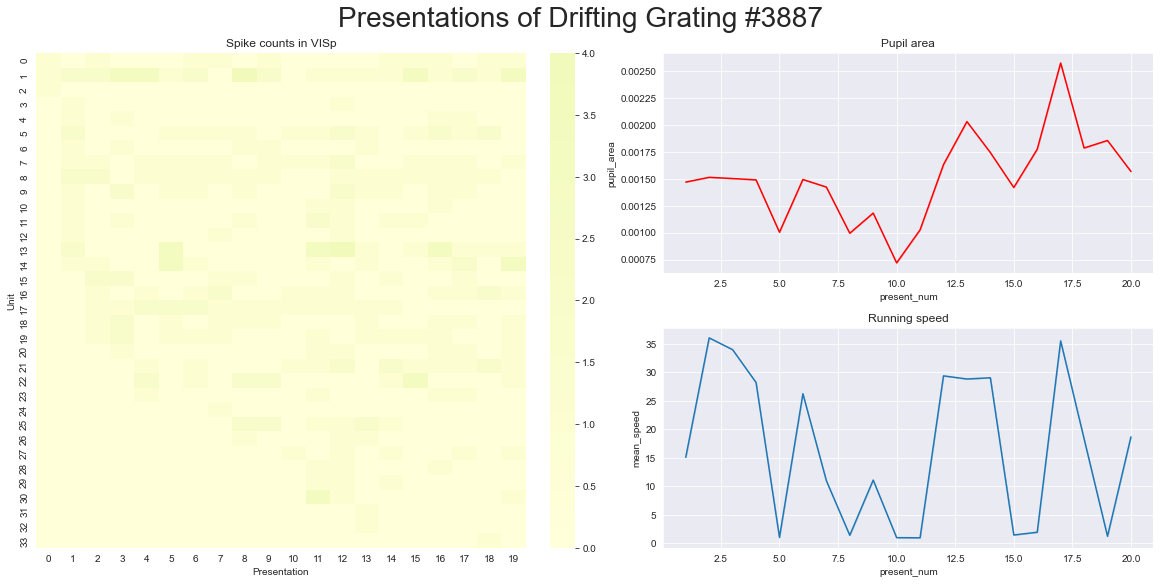

In [159]:
fig = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig)
fig.suptitle(f"Presentations of Drifting Grating #{stim_id}", fontsize=28)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

# Plot spike counts
plot = sns.heatmap(data, ax=ax1, center=20, cmap="YlGnBu")
plot.set(
    title=f"Spike counts in {roi}",
    xlabel='Presentation',
    ylabel="Unit"
)

# Plot pupil diameter
plot = sns.lineplot(x='present_num', y="pupil_area", color='red', ax=ax2, data=df)
plot.set_title(f"Pupil area")


# Plot running speed
plot = sns.lineplot(x='present_num', y="mean_speed", ax=ax3, data=df)
plot.set_title(f"Running speed")

# Natural Movie

Let's try all the above steps for a natural movie too. For the movies, there has to be time-binning and counting of spikes in a bin. It's not that different from counting spikes after single stimulus presentation.

In [ ]:
total_dur = 30

In [44]:
stim_type = 'natural_movie_one'
session.stimulus_conditions.loc[session.stimulus_conditions.stimulus_name == stim_type]

,color,contrast,frame,mask,opacity,orientation,phase,size,spatial_frequency,stimulus_name,temporal_frequency,units,x_position,y_position,color_triplet
stimulus_condition_id,,,,,,,,,,,,,,,
3887,null,1.0,0.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
3888,null,1.0,1.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
3889,null,1.0,2.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
3890,null,1.0,3.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
3891,null,1.0,4.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782,null,1.0,895.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
4783,null,1.0,896.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"
4784,null,1.0,897.0,null,1.0,0.0,null,"[1920.0, 1080.0]",null,natural_movie_one,null,pix,null,null,"[1.0, 1.0, 1.0]"


In [71]:
n_movie_frames = np.arange(0, 900).reshape(30, 30)
n_first_frames = np.arange(0, 900, 30).astype(int)

In [81]:
stim_type = 'natural_movie_one'
sec = 1  # just looking at the first second of the movie
roi = 'VISp'

# get just one time bin
# stim_id = session.stimulus_conditions.loc[session.stimulus_conditions.stimulus_name == stim_type].index.values[n_movie_frames[sec - 1]]

stim_id = session.stimulus_conditions.loc[session.stimulus_conditions.stimulus_name == stim_type].index.values[n_first_frames[sec - 1]]

stim_idx = session.stimulus_presentations.loc[session.stimulus_presentations.stimulus_condition_id == stim_id].index.values
#
# stim_idx = session.stimulus_presentations.loc[session.stimulus_presentations.stimulus_condition_id.isin(stim_id)].index.values

# select the roi and also drop low-snr units
q25 = np.percentile(session.units.snr, 25)
# mean_snr = session.units.snr.mean()
roi_idx = session.units[(session.units.snr > q25) & (session.units.ecephys_structure_acronym == roi)].index.values

In [82]:
stim_times = session.stimulus_presentations.loc[stim_idx, ["start_time"]]
stim_times["relative_time"] = (stim_times["start_time"] - stim_times["start_time"].min()) / 60
stim_times

,start_time,relative_time
stimulus_presentation_id,,
22000,2846.623389,0.000000
22900,2876.648499,0.500419
23800,2906.673539,1.000836
24700,2936.698659,1.501254
25600,2966.723719,2.001672
26500,2996.748779,2.502090
27400,3026.773889,3.002508
28300,3056.798959,3.502926
29200,3086.824039,4.003344


In [121]:
time_step = 0.001
time_bins = np.arange(0, 1, time_step)
# time_bins = [0, .99]
spike_cnts = session.presentationwise_spike_counts(
    stimulus_presentation_ids=stim_idx,
    unit_ids=roi_idx,
    bin_edges=time_bins
)
cnts = spike_cnts.to_dataframe()
# cnts.reset_index(inplace=True)

In [ ]:
# plot
mean_histograms = spike_cnts.mean(dim="stimulus_presentation_id")

fig, ax = plt.subplots(figsize=(8, 8))
ax.pcolormesh(
    mean_histograms["time_relative_to_stimulus_onset"],
    np.arange(mean_histograms["unit_id"].size),
    mean_histograms.T,
    vmin=0,
    vmax=1
)

ax.set_ylabel("unit", fontsize=24)
ax.set_xlabel("time relative to stimulus onset (s)", fontsize=18)
ax.set_title("Average peristimulus time histograms for VISp units on Natural Movie presentations (sec 1)", fontsize=18)

plt.show()

In [ ]:
# Another way of doing it
time_bins = [0, .99]
spike_cnts = session.presentationwise_spike_counts(
    stimulus_presentation_ids=stim_idx,
    unit_ids=roi_idx,
    bin_edges=time_bins
)
cnts2 = spike_cnts.to_dataframe()
cnts2.reset_index(inplace=True)

In [125]:
# Put stimulus properties next to the count data
cols = ["start_time", "stop_time", "stimulus_block", "stimulus_name", "stimulus_condition_id"]
all_counts = pd.merge(cnts, session.stimulus_presentations[cols], left_on="stimulus_presentation_id", right_index=True)
all_counts.reset_index(inplace=True)

In [126]:
# Count the number of spikes for each stimulus presentation in the whole duration
grp_cols = ["stimulus_presentation_id", "unit_id"] + cols
spikes_grpd = all_counts.groupby(grp_cols, as_index=False)["spike_counts"].sum()
spikes_grpd

,stimulus_presentation_id,unit_id,start_time,stop_time,stimulus_block,stimulus_name,stimulus_condition_id,spike_counts
0,22000,951877136,2846.623389,2846.65675,4.0,natural_movie_one,3887,7
1,22000,951877260,2846.623389,2846.65675,4.0,natural_movie_one,3887,23
2,22000,951877272,2846.623389,2846.65675,4.0,natural_movie_one,3887,15
3,22000,951877312,2846.623389,2846.65675,4.0,natural_movie_one,3887,0
4,22000,951877352,2846.623389,2846.65675,4.0,natural_movie_one,3887,0
...,...,...,...,...,...,...,...,...
855,65218,951878648,7980.930209,7980.96357,12.0,natural_movie_one,3887,23
856,65218,951878811,7980.930209,7980.96357,12.0,natural_movie_one,3887,3
857,65218,951878821,7980.930209,7980.96357,12.0,natural_movie_one,3887,12
858,65218,951878911,7980.930209,7980.96357,12.0,natural_movie_one,3887,1


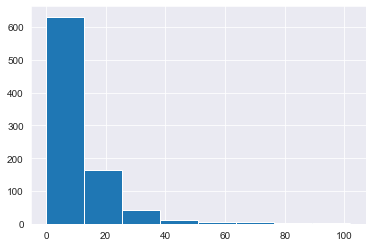

In [128]:
# Sanity check plots
p = plt.hist(spikes_grpd["spike_counts"], 8)

In [130]:
# This is the final spike counts for this stimulus and this region
df = spikes_grpd.copy()
df["roi"] = roi
df["movie_sec"] = sec
df

,stimulus_presentation_id,unit_id,start_time,stop_time,stimulus_block,stimulus_name,stimulus_condition_id,spike_counts,roi,movie_sec
0,22000,951877136,2846.623389,2846.65675,4.0,natural_movie_one,3887,7,VISp,1
1,22000,951877260,2846.623389,2846.65675,4.0,natural_movie_one,3887,23,VISp,1
2,22000,951877272,2846.623389,2846.65675,4.0,natural_movie_one,3887,15,VISp,1
3,22000,951877312,2846.623389,2846.65675,4.0,natural_movie_one,3887,0,VISp,1
4,22000,951877352,2846.623389,2846.65675,4.0,natural_movie_one,3887,0,VISp,1
...,...,...,...,...,...,...,...,...,...,...
855,65218,951878648,7980.930209,7980.96357,12.0,natural_movie_one,3887,23,VISp,1
856,65218,951878811,7980.930209,7980.96357,12.0,natural_movie_one,3887,3,VISp,1
857,65218,951878821,7980.930209,7980.96357,12.0,natural_movie_one,3887,12,VISp,1
858,65218,951878911,7980.930209,7980.96357,12.0,natural_movie_one,3887,1,VISp,1


In [161]:
run

,start_time,end_time,velocity,speed
0,24.21410,24.22951,9.269626,9.269626
1,24.24623,24.26278,4.645555,4.645555
2,24.26278,24.27961,6.774521,6.774521
3,24.29618,24.31293,2.550545,2.550545
4,24.31293,24.32949,0.563078,0.563078
...,...,...,...,...
365906,9211.73925,9211.75602,29.042203,29.042203
365907,9211.77252,9211.78949,29.092734,29.092734
365908,9211.82261,9211.83924,28.297820,28.297820
365909,9211.83924,9211.85622,24.425639,24.425639


In [162]:
# Put in the running speed
for idx in stim_idx:
    start = df.loc[df.stimulus_presentation_id == idx, "start_time"].mean()  # these are all the same number for one index
    stop = start + 1
    median_speed = run.loc[(run["start_time"] > start) & (run["end_time"] < stop), "speed"].median()
    mean_speed = run.loc[(run["start_time"] > start) & (run["end_time"] < stop), "speed"].mean()

    df.loc[df.stimulus_presentation_id == idx, "median_speed"] = median_speed
    df.loc[df.stimulus_presentation_id == idx, "mean_speed"] = mean_speed

# Put in the pupil area
for idx in stim_idx:
    start = df.loc[df.stimulus_presentation_id == idx, "start_time"].mean()
    stop = start + 1
    area = pupil.loc[(pupil.index > start) & (pupil.index < stop), "raw_pupil_area"].mean()
    df.loc[df.stimulus_presentation_id == idx, "pupil_area"] = area

In [163]:
# Making a matrix of unit x presentation to plot on a heatmap
# the issue here is that some of the units have no spike counts for some presentations
# so I have to find those and put 0 value for them

# TODO: IT'S BETTER TO DO THIS IN THE ORIGINAL DATAFRAME

units = df.unit_id.unique()
pres = df.stimulus_presentation_id.unique()

for u, unit in enumerate(units):
    df.loc[df.unit_id == unit, "unit_num"] = u + 1

for p, pre in enumerate(pres):
    df.loc[df.stimulus_presentation_id == pre, "present_num"] = p + 1

data = np.zeros((units.shape[0], pres.shape[0]))

for unit in df.unit_num.unique():
    for pres in df.present_num.unique():
        try:
            data[int(unit - 1), int(pres - 1)] = df.loc[(df.unit_num == unit) & (df.present_num == pres), "spike_count"].values[0]
        except IndexError:
            pass

Text(0.5, 1.0, 'Running speed')

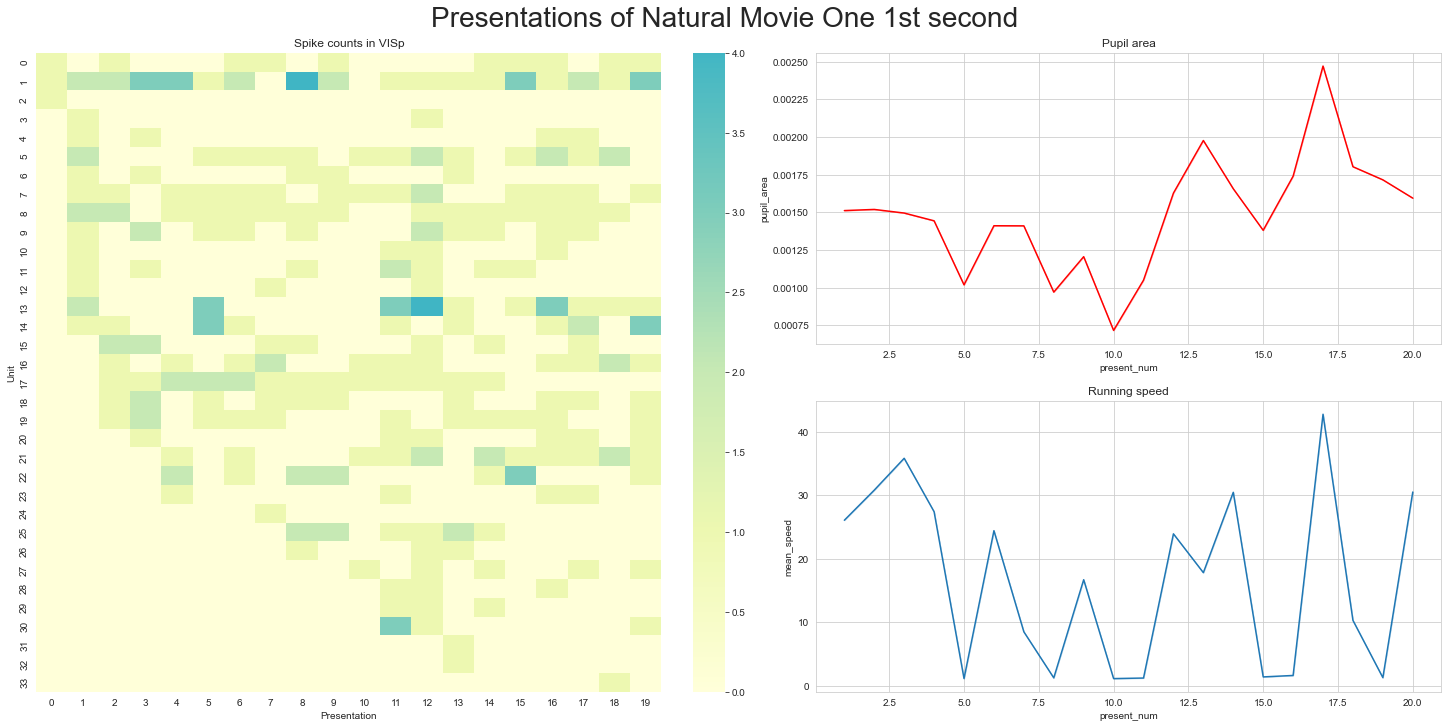

In [168]:
fig = plt.figure(figsize=(20, 10), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig)
fig.suptitle(f"Presentations of Natural Movie One 1st second", fontsize=28)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

# Plot spike counts
plot = sns.heatmap(data, ax=ax1, center=4, cmap="YlGnBu")
# plot = sns.heatmap(data, ax=ax1, center=20, cmap='rocket')
plot.set(
    title=f"Spike counts in {roi}",
    xlabel='Presentation',
    ylabel="Unit"
)

# Plot pupil diameter
plot = sns.lineplot(x='present_num', y="pupil_area", color='red', ax=ax2, data=df)
plot.set_title(f"Pupil area")


# Plot running speed
plot = sns.lineplot(x='present_num', y="mean_speed", ax=ax3, data=df)
plot.set_title(f"Running speed")

In [196]:
pupil

,raw_pupil_area
Time (s),
3.14509,0.005578
3.16893,0.005606
3.17042,0.005553
3.20369,0.005555
3.25324,0.005536
...,...
9835.50654,0.013549
9835.53988,0.013787
9835.57330,0.014223


C:\Users\shari\miniconda3\envs\neuro\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


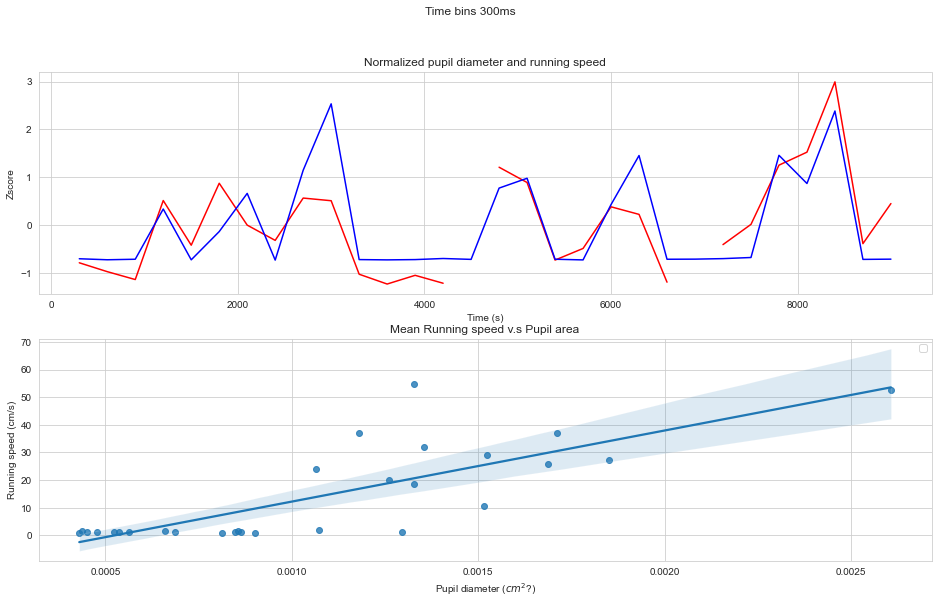

In [249]:
# Correlation between pupil size and running speed
# # select overlapping times for pupil measurements
# pupil_ = pupil[(pupil.index >= run.start_time.min()) & (pupil.index <= run.end_time.max())]

# get timepoints to plot, pupil data is longer
time_bins = np.arange(0, pupil.index.max().astype(int), 300)

# get pupil mean for each bin
pupil_mean = np.array([pupil.loc[(pupil.index > b) & (pupil.index < b + 1), "raw_pupil_area"].mean() for b in time_bins])
# pupil_mean = pupil_mean[~np.isnan(pupil_mean)]
pupil_normal = stats.zscore(pupil_mean, nan_policy='omit')
pupil_normal[pupil_normal > 3] = 0

# get running speed mean for each bin
run_mean = np.array([run.loc[(run.start_time > b) & (run.end_time < b + 1), "speed"].mean() for b in time_bins])
# run_mean = run_mean[~np.isnan(run_mean)]
run_normal = stats.zscore(run_mean, nan_policy='omit')

# plot
fig, axes = plt.subplots(2, 1, figsize=(16, 9))
fig.suptitle("Time bins 300ms")

# plot against time
axes[0].plot(time_bins, pupil_normal, 'r-', label="Pupil area")
axes[0].plot(time_bins, run_normal, 'b-', label="Running speed")

axes[0].set_title("Normalized pupil diameter and running speed")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Zscore")

# plot against each other
# pupil_ = pupil.loc[(pupil.index >= run.start_time.min()) & (pupil.index <= run.end_time.max()), "raw_pupil_area"]
# axes[1].scatter(pupil_mean, run_mean)
plot = sns.regplot(pupil_mean, run_mean, scatter=True, ax=axes[1])

axes[1].set_title("Mean Running speed v.s Pupil area")
axes[1].set_xlabel("Pupil diameter ($cm^2$?)")
axes[1].set_ylabel("Running speed (cm/s)")

plt.legend()
plt.show()

## Questions

- What SNR is acceptable? (currently dropping everything under 1st quantile)
- How long after stimulus onset are we looking at? 
- What time interval (before and after stimulus onset) should we look at for behavior? What's the metric? (currently looking at 0 to 0.5s and using median) It might also be a good idea to normalize based on a block's average speed. 
